## Gala Groceries - Modelling


<u>Problem statement:</u>
```
Can we accurately predict the stock levels of products, based on sales data and sensor data, 
on an hourly basis in order to more intelligently procure products from our suppliers.
```

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
sales_df = pd.read_csv("sales.csv")
print(sales_df.shape); sales_df.head(2)

(7829, 10)


,Unnamed: 0,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:51:38,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:33:59,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet


In [3]:
stock_df = pd.read_csv("sensor_stock_levels.csv")
print(stock_df.shape); stock_df.head(2)

(15000, 5)


,Unnamed: 0,id,timestamp,product_id,estimated_stock_pct
0,0,4220e505-c247-478d-9831-6b9f87a4488a,2022-03-07 12:13:02,f658605e-75f3-4fed-a655-c0903f344427,0.75
1,1,f2612b26-fc82-49ea-8940-0751fdd4d9ef,2022-03-07 16:39:46,de06083a-f5c0-451d-b2f4-9ab88b52609d,0.48


In [4]:
temp_df = pd.read_csv("sensor_storage_temperature.csv")
print(temp_df.shape); temp_df.head(2)

(23890, 4)


,Unnamed: 0,id,timestamp,temperature
0,0,d1ca1ef8-0eac-42fc-af80-97106efc7b13,2022-03-07 15:55:20,2.96
1,1,4b8a66c4-0f3a-4f16-826f-8cf9397e9d18,2022-03-01 09:18:22,1.88


### Data Cleaning

In [5]:
dfs = {'sales_df': sales_df, 'stock_df': stock_df, 'temp_df': temp_df}

In [6]:
for name, df in dfs.items():
    df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')  # Drop unnecessary columns
    print(f"\033[1m{name}\033[0m")
    print(f"{df.info()}\n")  # Information about the dataset

sales_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  7829 non-null   object 
 1   timestamp       7829 non-null   object 
 2   product_id      7829 non-null   object 
 3   category        7829 non-null   object 
 4   customer_type   7829 non-null   object 
 5   unit_price      7829 non-null   float64
 6   quantity        7829 non-null   int64  
 7   total           7829 non-null   float64
 8   payment_type    7829 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 550.6+ KB
None

stock_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  object 
 1   timestamp            15000 non-null  object 
 2 

In [7]:
# Convert timestamp column to datetime format and format it to include only year-month-day hour
for name, df in dfs.items():
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S').dt.round('h')

In [8]:
# Check if any duplicates exist
for name,df in dfs.items():
    print(df.duplicated().any())  

False
False
False


In [9]:
# Dataframe Unique Value Summary
for name,df in dfs.items():
    print(f"\033[1m{name}\033[0m\n{df.nunique()}\n")

sales_df
transaction_id    7829
timestamp           84
product_id         300
category            22
customer_type        5
unit_price          64
quantity             4
total              256
payment_type         4
dtype: int64

stock_df
id                     15000
timestamp                 84
product_id               300
estimated_stock_pct      100
dtype: int64

temp_df
id             23890
timestamp         84
temperature     3140
dtype: int64



### Merge datasets

`stock_df` is linked with `sales_df` by `product_id` and `timestamp`.  
`temp_df` is linked with `sales_df` by `timestamp`.

In [10]:
sales_agg = sales_df.groupby(['timestamp','product_id']).agg({'quantity':'sum'}).reset_index()
print(sales_agg.shape); sales_agg.head(2)

(6278, 3)


,timestamp,product_id,quantity
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,3
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3


In [11]:
stock_agg = stock_df.groupby(['timestamp','product_id']).agg({'estimated_stock_pct':'mean'}).reset_index()
print(stock_agg.shape); stock_agg.head(2)

(11025, 3)


,timestamp,product_id,estimated_stock_pct
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14


In [12]:
merge_df = sales_agg.merge(stock_agg, how='right', on=['timestamp','product_id'])
print(merge_df.shape); merge_df.head(2)

(11025, 4)


,timestamp,product_id,quantity,estimated_stock_pct
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,3.0,0.89
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3.0,0.14


In [13]:
merge_df['quantity'].isnull().sum()

8053

```
If there is a null value for `quantity`, it represents that there were 0 sales of this product within this hour.

So, lets fill this columns null values with 0, however, we should verify this with the client, in order to make sure we're not making any assumptions by filling these null values with 0.
```

In [14]:
# Fill missing values in the 'quantity' column with 0
merge_df['quantity'] = merge_df['quantity'].fillna(0)

In [15]:
temp_agg = temp_df.groupby(['timestamp']).agg({'temperature':'mean'}).reset_index()
print(temp_agg.shape); temp_agg.head(2)

(84, 2)


,timestamp,temperature
0,2022-03-01 09:00:00,-0.192988
1,2022-03-01 10:00:00,1.695658


In [16]:
merge_df = merge_df.merge(temp_agg, how='left', on=['timestamp'])
print(merge_df.shape); merge_df.head(2)

(11025, 5)


,timestamp,product_id,quantity,estimated_stock_pct,temperature
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,3.0,0.89,-0.192988
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3.0,0.14,-0.192988


In [17]:
merge_df['temperature'].isnull().sum()

0

In [18]:
product_details = sales_df[['product_id','category','unit_price']].drop_duplicates()
print(product_details.shape); product_details.head(2)

(300, 3)


,product_id,category,unit_price
0,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,3.99
1,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,3.99


In [19]:
merge_df = merge_df.merge(product_details, how='left', on='product_id')
print(merge_df.shape); merge_df.head(2)

(11025, 7)


,timestamp,product_id,quantity,estimated_stock_pct,temperature,category,unit_price
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,3.0,0.89,-0.192988,kitchen,11.19
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3.0,0.14,-0.192988,vegetables,1.49


### Feature Engineering

In [32]:
final_df = merge_df.copy()
final_df.head(2); final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11025 entries, 0 to 11024
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            11025 non-null  datetime64[ns]
 1   product_id           11025 non-null  object        
 2   quantity             11025 non-null  float64       
 3   estimated_stock_pct  11025 non-null  float64       
 4   temperature          11025 non-null  float64       
 5   category             11025 non-null  object        
 6   unit_price           11025 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 603.1+ KB


In [33]:
final_df['day_of_month'] = final_df['timestamp'].dt.day.astype('uint8')
final_df['day_of_week'] = final_df['timestamp'].dt.day_of_week.astype('uint8')
final_df['hour'] = final_df['timestamp'].dt.hour.astype('uint8')
final_df.drop(columns=['timestamp'],inplace=True)
print(final_df.shape); final_df.head(2)

(11025, 9)


,product_id,quantity,estimated_stock_pct,temperature,category,unit_price,day_of_month,day_of_week,hour
0,00e120bb-89d6-4df5-bc48-a051148e3d03,3.0,0.89,-0.192988,kitchen,11.19,1,1,9
1,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3.0,0.14,-0.192988,vegetables,1.49,1,1,9


**OHE of (category) & W/O product_id**

In [22]:
final_df = pd.get_dummies(final_df, columns=['category'], dtype='uint8')
final_df.drop(columns=['product_id'],inplace=True)

**OHE of (product_id & category)**

In [36]:
cat_columns = ['product_id','category']
final_df = pd.get_dummies(final_df, columns=cat_columns, dtype='uint8')

**OHE of  (product_id, category, day_of_month, day_of_week, hour)**

In [94]:
cat_columns = ['product_id','category','day_of_month','day_of_week','hour']
final_df = pd.get_dummies(final_df, columns=cat_columns, dtype='uint8')

**Type='category' for (product_id & category)**

In [25]:
cat_columns = ['product_id','category']
final_df[cat_columns] = final_df[cat_columns].astype('category')

**Type='category' for (product_id, category, day_of_month, day_of_week, hour)**

In [34]:
cat_columns = ['product_id','category','day_of_month','day_of_week','hour']
final_df[cat_columns] = final_df[cat_columns].astype('category')

### Pre Processing

In [35]:
print(final_df.shape); final_df.head(2)

(11025, 9)


,product_id,quantity,estimated_stock_pct,temperature,category,unit_price,day_of_month,day_of_week,hour
0,00e120bb-89d6-4df5-bc48-a051148e3d03,3.0,0.89,-0.192988,kitchen,11.19,1,1,9
1,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3.0,0.14,-0.192988,vegetables,1.49,1,1,9


In [36]:
X = final_df.drop(columns=['estimated_stock_pct'], axis=1)
y = final_df['estimated_stock_pct']

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train: {X_train.shape}  y_train: {y_train.shape}')
print(f'X_test:  {X_test.shape}    y_test: {y_test.shape}')

X_train: (8820, 8)  y_train: (8820,)
X_test:  (2205, 8)    y_test: (2205,)


#### Standardisation

In [38]:
X.head(2)

,product_id,quantity,temperature,category,unit_price,day_of_month,day_of_week,hour
0,00e120bb-89d6-4df5-bc48-a051148e3d03,3.0,-0.192988,kitchen,11.19,1,1,9
1,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3.0,-0.192988,vegetables,1.49,1,1,9


**With (category) as OHE and W/O product_id --------or--------  With (product_id & category) as OHE**

In [27]:
# Standardisation of numerical features of x_train
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

X_train.iloc[:,:6] = std_scaler.fit_transform(X_train.iloc[:,:6])
X_test.iloc[:,:6] = std_scaler.transform(X_test.iloc[:,:6])

**With (product_id, category, day_of_month, day_of_week, hour) as OHE**

In [32]:
# Standardisation of numerical features of x_train
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

float_col = [idx for idx, dtype in enumerate(X.dtypes) if 'float' in str(dtype)]
X_train.iloc[:,float_col] = std_scaler.fit_transform(X_train.iloc[:,float_col])
X_test.iloc[:,float_col] = std_scaler.transform(X_test.iloc[:,float_col])

**With Categorical columns**

In [39]:
# Standardisation of numerical features of x_train
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

non_cat_col = [idx for idx, dtype in enumerate(X.dtypes) if dtype.kind in ['i', 'u', 'f']]
X_train.iloc[:,non_cat_col] = std_scaler.fit_transform(X_train.iloc[:,non_cat_col])
X_test.iloc[:,non_cat_col] = std_scaler.transform(X_test.iloc[:,non_cat_col])

### Functions

In [28]:
def print_cross_val_score(estimator, X, y, cv=5, **kwargs):
    import numpy as np
    from sklearn.model_selection import cross_val_score
    accuracy = cross_val_score(estimator, X, y, cv=cv, **kwargs)
    print(f'Cross Validation Score ({cv} Fold)')
    print(f"Accuracy Mean : {np.mean(accuracy)} ")
    print(f"Accuracy Std  : {np.std(accuracy)*100:.2f} %")

In [29]:
def print_eval_metric(y_true, y_pred, n_features):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    for metric in [mean_absolute_error, mean_squared_error, r2_score]:
        print(f"{metric.__name__} : {metric(y_true, y_pred)}")
    n = y_true.shape[0]
    p = n_features
    adjusted_r_squared = 1 - (1 - r2_score(y_true, y_pred)) * (n - 1) / (n - p - 1)
    print(f"adjusted_r2: {adjusted_r_squared}")

### Modelling

#### CatBoost

In [40]:
from catboost import CatBoostRegressor

cat_columns = [col for col in X_train.select_dtypes('category').columns]
catboost_reg = CatBoostRegressor(cat_features=cat_columns, verbose=False, random_state=42)
catboost_reg.fit(X_train, y_train)
y_pred_catboost = catboost_reg.predict(X_test)

**With (product_id, category, day_of_month, day_of_week, hour) as Cat**

In [ ]:
print_cross_val_score(catboost_reg, X_train, y_train, cv=10)

In [41]:
print_eval_metric(y_test, y_pred_catboost, n_features=X_test.shape[1])

mean_absolute_error : 0.22330549626951016
mean_squared_error : 0.06984075435155469
r2_score : -0.015859267330865734
adjusted_r2: -0.01956002968908388


**With (product_id & category) as Cat**

In [45]:
print_cross_val_score(catboost_reg, X_train, y_train, cv=10)

Cross Validation Score (10 Fold)
Accuracy Mean : -0.030805452920506272 
Accuracy Std  : 1.41 %


In [44]:
print_eval_metric(y_test, y_pred_catboost, n_features=X_test.shape[1])

mean_absolute_error : 0.22558049170451833
mean_squared_error : 0.07195492100335407
r2_score : -0.033028491731409204
adjusted_r2: -0.03534340151680171


**With (category) as Cat and W/O product_id**

In [44]:
print_cross_val_score(catboost_reg, X_train, y_train, cv=10)

Cross Validation Score (10 Fold)
Accuracy Mean : -0.07680807366748996 
Accuracy Std  : 1.50 %


In [45]:
print_eval_metric(y_test, y_pred_catboost, n_features=X_test.shape[1])

mean_absolute_error : 0.22947017260488484
mean_squared_error : 0.07467748253906709
r2_score : -0.07211523656644925
adjusted_r2: -0.08057135674218463


**With (product_id & category) as OHE**

In [38]:
print_cross_val_score(catboost_reg, X_train, y_train, cv=10)

Cross Validation Score (10 Fold)
Accuracy Mean : -0.04813271672972554 
Accuracy Std  : 1.66 %


In [39]:
print_eval_metric(y_test, y_pred_catboost, n_features=X_test.shape[1])

mean_absolute_error : 0.22763586725456125
mean_squared_error : 0.07358621740485435
r2_score : -0.0564483723693181
adjusted_r2: -0.16306839271920626


**With (product_id, category, day_of_month, day_of_week, hour) as OHE**

In [40]:
print_cross_val_score(catboost_reg, X_train, y_train, cv=10)

Cross Validation Score (10 Fold)
Accuracy Mean : -0.04292175652390127 
Accuracy Std  : 1.11 %


In [39]:
print_eval_metric(y_test, y_pred_catboost, n_features=X_test.shape[1])

mean_absolute_error : 0.22480498639280713
mean_squared_error : 0.07131503529820227
r2_score : -0.03730322188442825
adjusted_r2: -0.23379185160997284


#### XGBoost

**With (product_id, category, day_of_month, day_of_week, hour) as Cat**

In [48]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(enable_categorical=True)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)

In [41]:
print_cross_val_score(xgb_reg, X_train, y_train, cv=10)

Cross Validation Score (10 Fold)
Accuracy Mean : -0.203030175522591 
Accuracy Std  : 3.48 %


In [42]:
print_eval_metric(y_test, y_pred_xgb, n_features=X_test.shape[1])

mean_absolute_error : 0.23891256826872725
mean_squared_error : 0.08236139915761997
r2_score : -0.18243020438753255
adjusted_r2: -0.19175641445030744


#### Random Forest Regression

**With (product_id & category) as OHE**

In [41]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

In [43]:
print_cross_val_score(rf_reg, X_train, y_train, cv=10)

Cross Validation Score (10 Fold)
Accuracy Mean : -0.11322051546437713 
Accuracy Std  : 2.17 %


In [42]:
print_eval_metric(y_test, y_pred_rf, n_features=X_test.shape[1])

mean_absolute_error : 0.22916885638699924
mean_squared_error : 0.07530690623915469
r2_score : -0.09536644194850274
adjusted_r2: -0.30285355534511593


#### Support Vector Regression

**With (product_id & category) as OHE**

In [45]:
from sklearn.svm import SVR
svm_reg = SVR(kernel='rbf')

svm_reg.fit(X_train,y_train)
y_pred_svm = svm_reg.predict(X_test)

In [47]:
print_cross_val_score(svm_reg, X_train, y_train, cv=10)

Cross Validation Score (10 Fold)
Accuracy Mean : -0.1942238000712925 
Accuracy Std  : 2.12 %


In [46]:
print_eval_metric(y_test, y_pred_svm, n_features=X_test.shape[1])

mean_absolute_error : 0.23638790454980615
mean_squared_error : 0.08058679807617751
r2_score : -0.1721643961364765
adjusted_r2: -0.3941987744656201


#### y_pred = Mean of y_train

In [49]:
y_pred = np.full(y_test.shape[0],np.mean(y_train))

In [50]:
print_eval_metric(y_test, y_pred, n_features=X_test.shape[1])

mean_absolute_error : 0.22207931024967306
mean_squared_error : 0.06876186024256153
r2_score : -0.00016635866649949982
adjusted_r2: -0.189620428764687


### Visualize Important Features

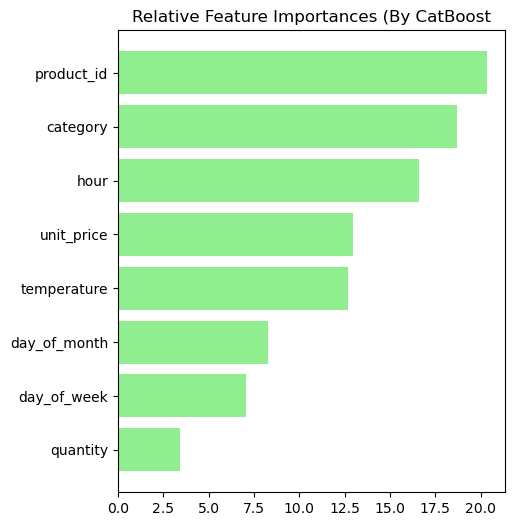

In [84]:
# Plot the relative feature importances from catboost model
features = [i for i in X.columns]
importances = catboost_reg.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(5,6))
plt.title('Relative Feature Importances (By CatBoost')
plt.barh(range(len(indices)), importances[indices], color='lightgreen', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices]); plt.show()

In [85]:
pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values('Importance',ascending=False)

,Feature,Importance
0,product_id,20.348038
3,category,18.703586
7,hour,16.589633
4,unit_price,12.936292
2,temperature,12.690409
5,day_of_month,8.258167
6,day_of_week,7.062340
1,quantity,3.411536


In [30]:
from sklearn.linear_model import LassoCV

# Fit Lasso model
lasso = LassoCV().fit(X_train, y_train)

# Get feature coefficients
coef = lasso.coef_

# Print the non-zero feature coefficients
print("Non-zero feature coefficients:")
for i in range(len(coef)):
    if coef[i] != 0:
        print(f"{X_train.columns[i]}: {coef[i]}")

Non-zero feature coefficients:
temperature: 0.0027417067263372213
unit_price: -0.0016986252573848826


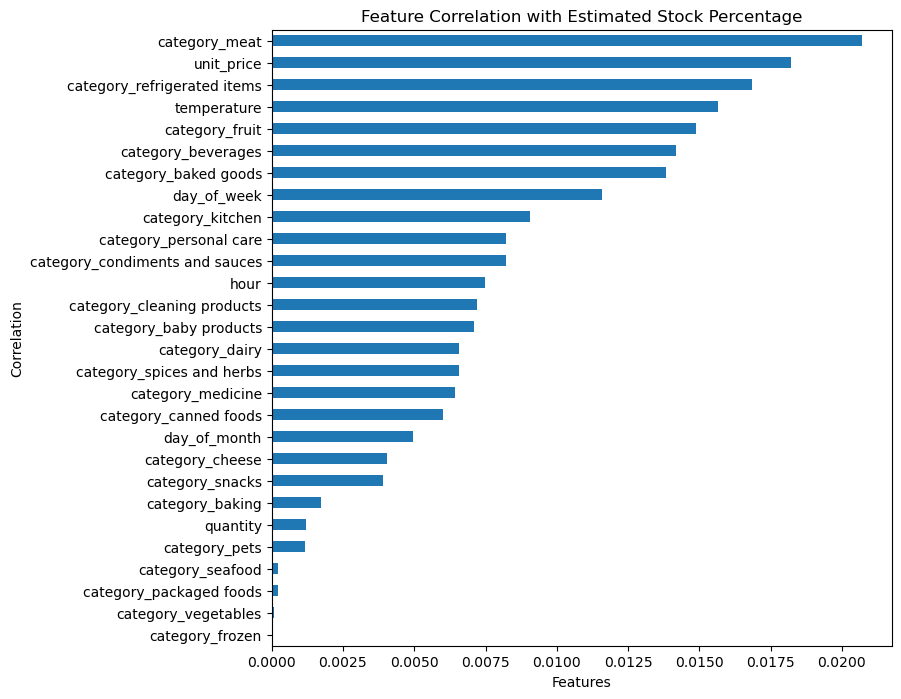

In [31]:
# Plot feature rankings based on correlation with target variable
feature_correlation = X.corrwith(y).abs().sort_values(ascending=True)
plt.figure(figsize=(8, 8))
feature_correlation.plot(kind='barh')
plt.title("Feature Correlation with Estimated Stock Percentage")
plt.ylabel("Correlation")
plt.xlabel("Features"); plt.show()